In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import warnings, pickle, os, json, copy
warnings.filterwarnings("ignore")

In [2]:
info_raw = pd.read_csv("data/inverse/info.csv")
ccba_raw = pd.read_csv("data/inverse/ccba.csv")
cdtx_raw = pd.read_csv("data/inverse/cdtx.csv")
dp_raw = pd.read_csv("data/inverse/dp.csv")
remit_raw = pd.read_csv("data/inverse/remit.csv")

In [3]:
info_raw["month"] = info_raw["date"].apply(lambda X: X[:7])
ccba_raw["month"] = ccba_raw["byymm"].apply(lambda X: X[:7])
info_raw = pd.merge(info_raw, ccba_raw, on = ["cust_id", "month"], how = "left")
info_raw = info_raw.drop(["month", "byymm"], axis = 1)
info_raw.head()

,alert_key,date,sar_flag,cust_id,risk_rank,occupation_code,total_asset,AGE,lupay,cycam,usgam,clamt,csamt,inamt,cucsm,cucah
0,171142,2021-04-01,0.0,a39fea9aec90969fe66a2b2b4d1b86368a2d38e8b8d4bf...,3,12.0,241719.0,3,12565.0,150744.0,82748.0,0.0,0.0,12477.0,12477.0,0.0
1,171152,2021-04-01,0.0,7e42b5dca9b28ee8e5545beb834361e90e6197d176b389...,3,13.0,599497.0,6,3581.0,324783.0,64363.0,0.0,0.0,0.0,4981.0,0.0
2,171177,2021-04-01,0.0,a6cdf6302aead77112013168c6d546d2df3bcb551956d2...,1,19.0,51160.0,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,171178,2021-04-01,0.0,1a3efa69705f611c7ef2384a715c8142e2ee801cfec9df...,3,9.0,3634343.0,6,829364.0,7666339.0,2343836.0,0.0,0.0,781279.0,781279.0,0.0
4,171180,2021-04-01,0.0,67f8cbb64dd3d447e992b1b299e0ceed3372188e47c88e...,1,17.0,4076287.0,4,636.0,256134.0,3538.0,0.0,0.0,0.0,3410.0,0.0


In [4]:
# dp以小時為單位，合併時需以當日最後的時間往前推
info_raw["date"] = pd.to_datetime(info_raw["date"] + " 23")

In [5]:
data_raw = [[cdtx_raw, 0, "date"], [dp_raw, 1, "tx_date"], [remit_raw, 2, "trans_date"], [info_raw, 3, "date"]]

In [6]:
def cyclical_feat_encode(df):
    df["date"] = pd.to_datetime(df["date"])

    df['month'] = df["date"].dt.month
    df['day'] = df["date"].dt.day

    df['month_sin'] = np.sin(2 * np.pi *  df['month']/ df["month"].max())
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / df["month"].max())

    df['day_sin'] = np.sin(2 * np.pi * df['day'] / df["day"].max())
    df['day_cos'] = np.cos(2 * np.pi * df['day'] / df["day"].max())

    df = df.drop(["month", "day"], axis = 1)
    
    return df

In [7]:
with open("feature_type.json", newline='') as file:
    feature_type = json.load(file)

In [8]:
def process_catgorical(df, col):
    df[col].fillna('NULL', inplace=True)
    map_dict = {v:i for i, v in enumerate(set(df[col].unique()))} #set可排序，NULL放最後
    df[col] = df[col].map(map_dict)
    return df

In [9]:
cust_id = {k: i for i, k in enumerate(info_raw["cust_id"].unique())}

for i in range(len(data_raw)):
    df = data_raw[i][0].copy()

    df = df.rename(columns = {data_raw[i][2]: "date"}) # 統一日期名稱
    df = df.drop(df[df["date"].isnull()].index)
    df["date"] = pd.to_datetime(df["date"]) #日期type轉換

    if data_raw[i][1] == 3:
        df = cyclical_feat_encode(df) # 時間特徵生成
    
    df["source"] = data_raw[i][1] # 資料源

    df["cust_id"] = df["cust_id"].map(cust_id) # label encoding
    
    # 缺失值處理
    for col in df.columns:
        if (feature_type[col] == "category") and (col not in ["sar_flag", "source"]):
            df = process_catgorical(df, col)
        elif (col not in ["sar_flag", "source"]):
            df[col].fillna(0, inplace=True)
    
    data_raw[i][0] = df

In [10]:
# 分群
data_g = copy.deepcopy(data_raw)
for df_g in data_g:
    df_g[0] = df_g[0].groupby("cust_id")

In [11]:
# 每個id每個info資料所涵蓋的區間之所有資料
data = {i:{} for i in cust_id.values()}

for id_ in cust_id.values():
    # 抓出id的所有資料
    cust_data1 = []
    for df_g, name, date_col in data_g:
        if id_ in df_g.groups:
            df1 = df_g.get_group(id_)
            cust_data1.extend(df1.to_dict('records'))

    # 依日期、資料源排序
    cust_data1 = sorted(cust_data1, key = lambda X: (X["date"].timestamp(), X["source"]))
    cust_data1 = np.array(cust_data1)

    #抓出各區間的資料
    cust_data2 = {}
    idx = 0
    start = 0
    for i, s in enumerate(cust_data1):
        if s["source"] == 3:
            cust_data2[idx] = {}
            end = i

            if not pd.isnull(cust_data1[end]["sar_flag"]):
                cust_data2[idx]["sar"] = cust_data1[end]["sar_flag"]
                cust_data2[idx]["data_type"] = "train"
            else:
                cust_data2[idx]["data_type"] = "test"


            cust_data2[idx]["data"] = cust_data1[start:end+1]
            start = end + 1
            idx += 1

    data[id_] = cust_data2
    
pickle.dump(data, open('data/inverse/cust_id1.pkl', 'wb'))

In [9]:
data = pickle.load(open('data/inverse/cust_id1.pkl', 'rb'))

In [15]:
data[1][4]

{'sar': 0.0,
 'data_type': 'train',
 'data': array([{'cust_id': 1, 'debit_credit': 0, 'date': Timestamp('2021-04-26 06:00:00'), 'tx_type': 1, 'tx_amt': 30229.0, 'exchg_rate': 1.0, 'info_asset_code': 16, 'fiscTxId': 29, 'txbranch': 349, 'cross_bank': 0, 'ATM': 0, 'source': 1},
        {'cust_id': 1, 'debit_credit': 0, 'date': Timestamp('2021-04-26 10:00:00'), 'tx_type': 0, 'tx_amt': 50382.0, 'exchg_rate': 1.0, 'info_asset_code': 12, 'fiscTxId': 29, 'txbranch': 349, 'cross_bank': 0, 'ATM': 0, 'source': 1},
        {'cust_id': 1, 'debit_credit': 1, 'date': Timestamp('2021-04-26 14:00:00'), 'tx_type': 1, 'tx_amt': 251926.0, 'exchg_rate': 1.0, 'info_asset_code': 13, 'fiscTxId': 4, 'txbranch': 168, 'cross_bank': 1, 'ATM': 1, 'source': 1},
        {'alert_key': 184066, 'date': Timestamp('2021-04-26 23:00:00'), 'sar_flag': 0.0, 'cust_id': 1, 'risk_rank': 3, 'occupation_code': 13, 'total_asset': 599497.0, 'AGE': 6, 'lupay': 3581.0, 'cycam': 324783.0, 'usgam': 64363.0, 'clamt': 0.0, 'csamt': 0.0

In [13]:
source_name = {
    0: "cdtx",
    1: "dp",
    2: "remit",
    3: "info"
}

In [14]:
# remit
for k1, v1 in data.items():
    for k2, v2 in v1.items():
        df = []
        new_feat = {}
        for v3 in v2["data"]:
            if v3["source"] == 2:
                df.append(v3)

        if len(df) != 0:
            df = pd.DataFrame(df)
            #計算類別變數的出現頻率
            count = df.groupby(["trans_no"])["source"].count()# 變數各種類別的次數
            count.index = [f"trans_{i}" for i in count.index]
            count = (count / len(df)).round(4)# 變數各種類別的占比
            count = count.to_dict()

            count["count"] = len(df)# 總交易次數


            new_feat["amt"] = df["trade_amount_usd"].sum()# 總交易金額
            
            IQR = df["trade_amount_usd"].quantile(0.75) - df["trade_amount_usd"].quantile(0.25)
            upper = df["trade_amount_usd"].quantile(0.75) + (1.5 * IQR) # 高於此值視為離群值，突然出現的較高交易金額

            new_feat["upper_amt"] = (df["trade_amount_usd"][(df["trade_amount_usd"] > upper)].sum() / df["trade_amount_usd"].sum()).round(4)# 高交易金額佔總額之比例

            new_feat["upper"] = (df["trade_amount_usd"] > upper).sum()# 高交易金額的次數
            new_feat["upper"] = (new_feat["upper"] / len(df)).round(4)# 高交易金額的占比
            new_feat.update(count)

            
            new_feat = {f"remit_{k}":v for k, v in new_feat.items()}
            v2["data"][-1].update(new_feat)

In [15]:
# cdtx
flag = 0
for k1, v1 in data.items():
    for k2, v2 in v1.items():
        df = []
        new_feat = {}
        for v3 in v2["data"]:
            if v3["source"] == 0:
                df.append(v3)

        if len(df) != 0:
            df = pd.DataFrame(df)
            #計算類別變數的出現頻率
            # count = df.groupby(["trans_no"])["source"].count()# 變數各種類別的次數
            # count.index = [f"trans_{i}" for i in count.index]
            # count = (count / len(df)).round(4)# 變數各種類別的占比
            # count = count.to_dict()

            # count["count"] = len(df)# 總交易次數


            new_feat["amt"] = df["amt"].sum()# 總交易金額
            
            IQR = df["amt"].quantile(0.75) - df["amt"].quantile(0.25)
            upper = df["amt"].quantile(0.75) + (1.5 * IQR) # 高於此值視為離群值，突然出現的較高交易金額

            new_feat["upper_amt"] = (df["amt"][(df["amt"] > upper)].sum() / df["amt"].sum()).round(4)# 高交易金額佔總額之比例

            new_feat["upper"] = (df["amt"] > upper).sum()# 高交易金額的次數
            new_feat["upper"] = (new_feat["upper"] / len(df)).round(4)# 高交易金額的占比
            # new_feat.update(count)

            
            new_feat = {f"cdtx_{k}":v for k, v in new_feat.items()}
            v2["data"][-1].update(new_feat)
            flag = 1
    #         break
    # if flag:
    #     break
        

In [16]:
# dp
flag = 0
for k1, v1 in data.items():
    for k2, v2 in v1.items():
        df = []
        new_feat = {}
        for v3 in v2["data"]:
            if v3["source"] == 1:
                df.append(v3)

        if len(df) != 0:
            df = pd.DataFrame(df)
            #計算類別變數的出現頻率
            # count = df.groupby(["trans_no"])["source"].count()# 變數各種類別的次數
            # count.index = [f"trans_{i}" for i in count.index]
            # count = (count / len(df)).round(4)# 變數各種類別的占比
            # count = count.to_dict()

            # count["count"] = len(df)# 總交易次數

            df["amt_ntd"] = df["tx_amt"] * df["exchg_rate"]
            new_feat["amt"] = df["amt_ntd"].sum()# 總交易金額
            
            IQR = df["amt_ntd"].quantile(0.75) - df["amt_ntd"].quantile(0.25)
            upper = df["amt_ntd"].quantile(0.75) + (1.5 * IQR) # 高於此值視為離群值，突然出現的較高交易金額

            new_feat["upper_amt"] = (df["amt_ntd"][(df["amt_ntd"] > upper)].sum() / df["amt_ntd"].sum()).round(4)# 高交易金額佔總額之比例

            new_feat["upper"] = (df["amt_ntd"] > upper).sum()# 高交易金額的次數
            new_feat["upper"] = (new_feat["upper"] / len(df)).round(4)# 高交易金額的占比
            # new_feat.update(count)
            
            new_feat = {f"dp_{k}":v for k, v in new_feat.items()}
            v2["data"][-1].update(new_feat)
    #         flag = 1
    #         break
    # if flag:
    #     break
        

In [17]:
# 抓出info data的資料
info = []
for k1, v1 in data.items():
    for k2, v2 in v1.items():
        for v3 in v2["data"]:
            if v3["source"] == 3:
                info.extend([v3])
df = pd.DataFrame(info)
df.head(3)

,alert_key,date,sar_flag,cust_id,risk_rank,occupation_code,total_asset,AGE,lupay,cycam,...,cdtx_upper,remit_amt,remit_upper_amt,remit_upper,remit_trans_4,remit_count,remit_trans_3,remit_trans_0,remit_trans_1,remit_trans_2
0,171142,2021-04-01 23:00:00,0.0,0,3,12,241719.0,3,12565.0,150744.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,171960,2021-04-06 23:00:00,0.0,0,3,12,241719.0,3,12565.0,150744.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,174802,2021-04-09 23:00:00,0.0,0,3,12,241719.0,3,12565.0,150744.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
df["am_pct"] = df.eval("cycam / usgam").replace(np.nan, 0).replace(np.inf, 0)

In [19]:
df.iloc[:, 4:] = df.iloc[:, 4:].fillna(0)

In [20]:
df = df.drop(["date", "source"], axis = 1)

In [21]:
target = "sar_flag"
train = df[~df[target].isnull()].reset_index(drop = True)
test = df[df[target].isnull()].reset_index(drop = True)

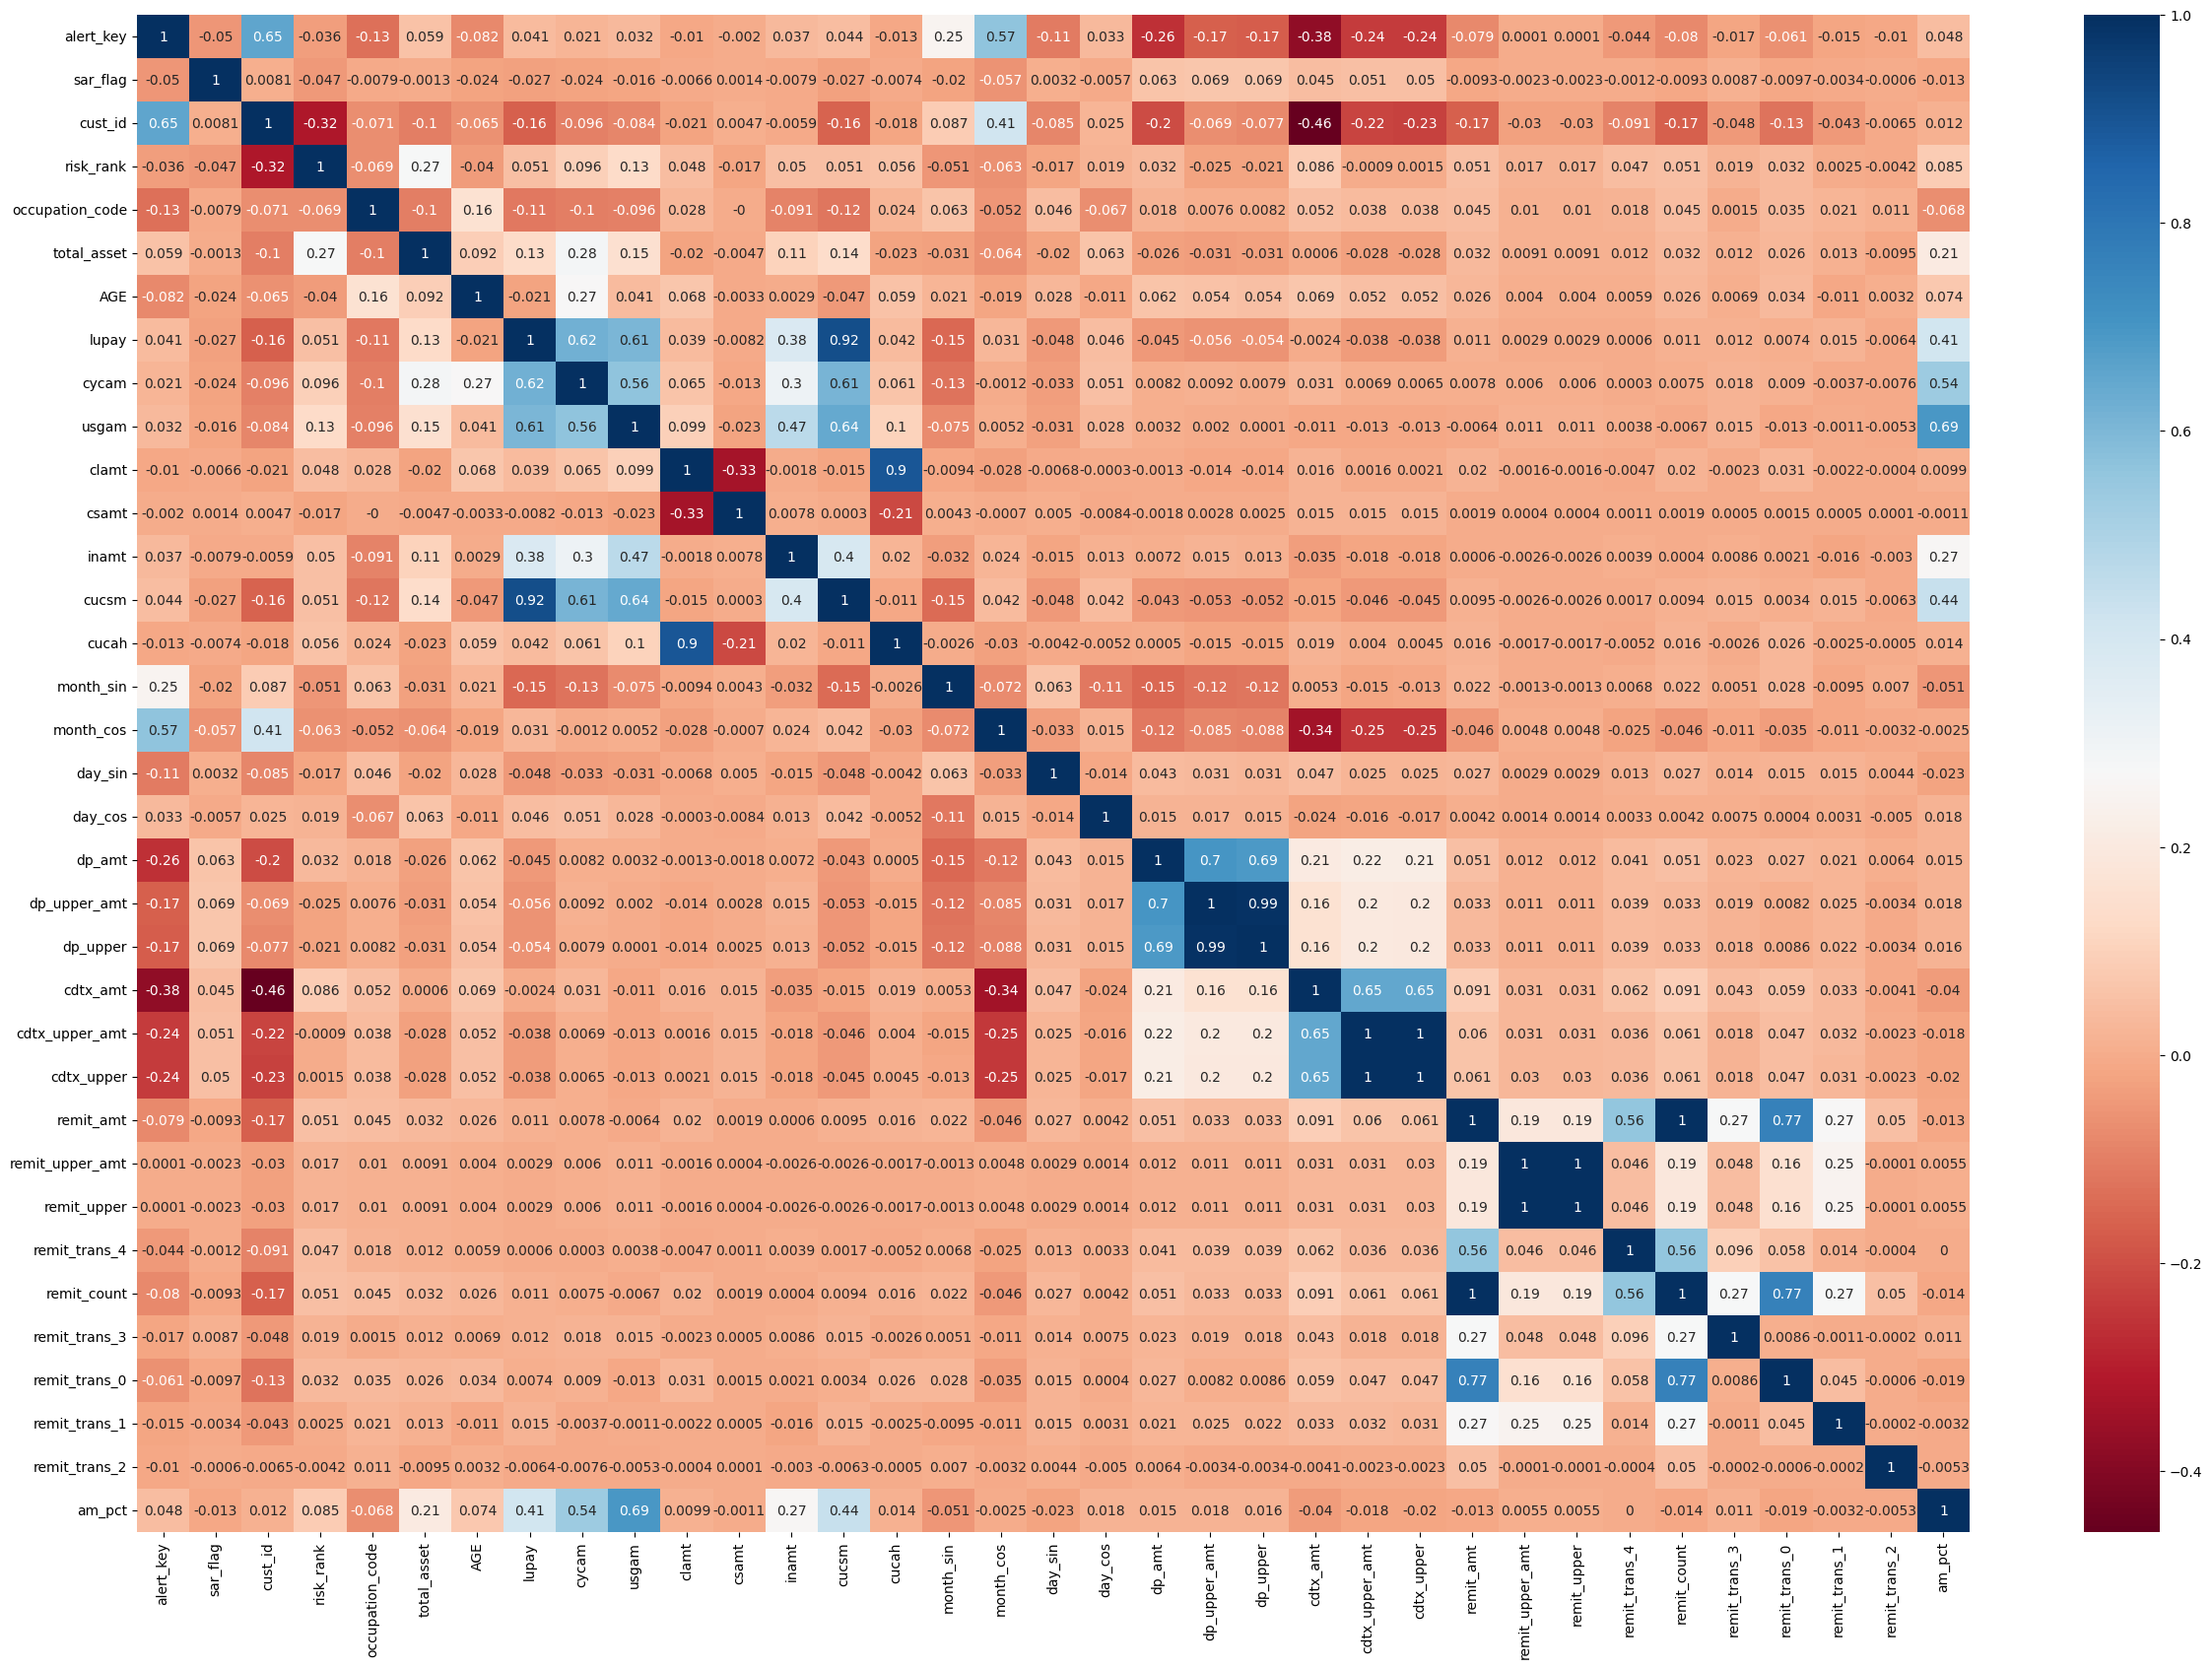

In [22]:
plt.figure(figsize=(30, 20))
corr = df.corr(method="spearman").round(4)
sns.heatmap(data = corr, annot=True, cmap = 'RdBu', annot_kws = {"fontsize": 10})
plt.show()

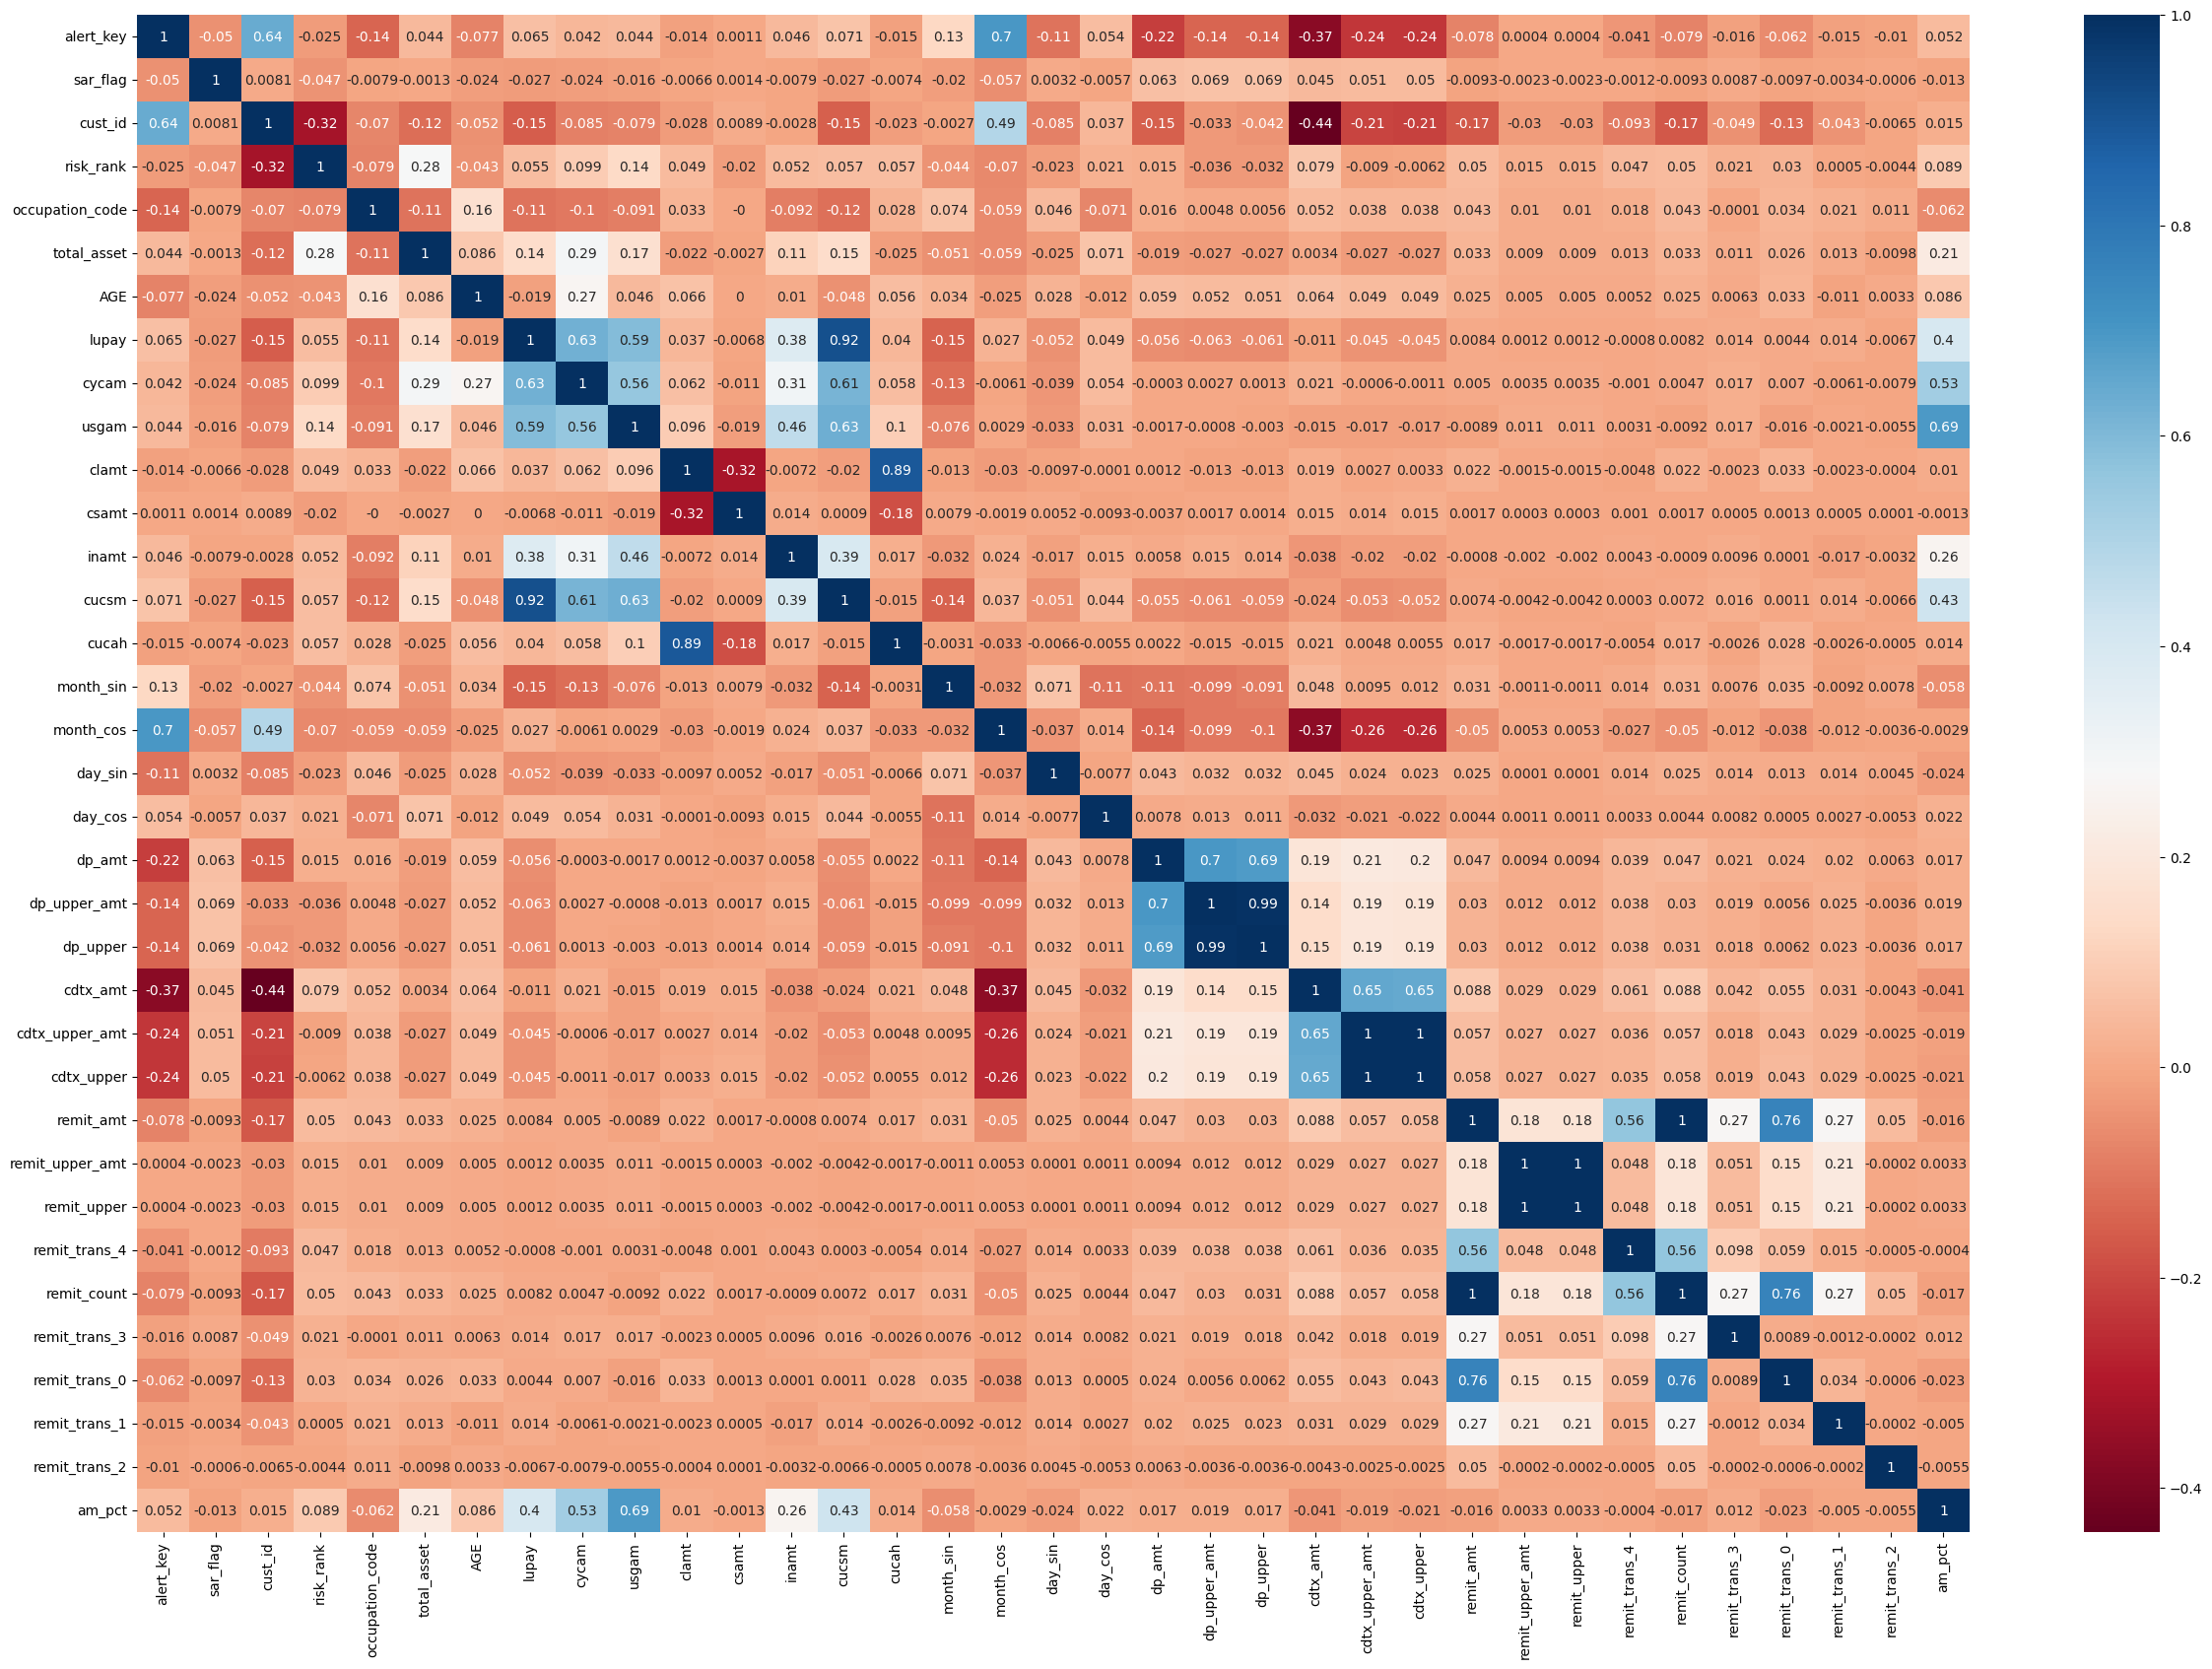

In [23]:
plt.figure(figsize=(30, 20))
corr = train.corr(method="spearman").round(4)
sns.heatmap(data = corr, annot=True, cmap = 'RdBu', annot_kws = {"fontsize": 10})
plt.show()

In [24]:
train = train.dropna().reset_index(drop = True)

# Split train、valid data

In [25]:
drop_feat = ["alert_key", "sar_flag"]

In [26]:
X_train = train.drop(drop_feat, axis = 1)
y_train = train["sar_flag"]

X_test = test.drop(drop_feat, axis = 1)

In [27]:
print(f"raw 1/0: {(y_train.value_counts()[1] / y_train.value_counts()[0]):.4}")
y_train.value_counts()

raw 1/0: 0.009885


0.0    23672
1.0      234
Name: sar_flag, dtype: int64

In [28]:
X_train1, X_valid, y_train1, y_valid = train_test_split(X_train, y_train, test_size=0.2, shuffle = True, stratify = y_train, random_state = 99)
# X_train1, X_valid, y_train1, y_valid = train_test_split(X_train, y_train, test_size=0.3, shuffle = False)
print(X_train1.shape, X_valid.shape, y_train1.shape, y_valid.shape)

(19124, 33) (4782, 33) (19124,) (4782,)


In [29]:
print(f"train 1/0: {(y_train1.value_counts()[1] / y_train1.value_counts()[0]):.4}")
y_train1.value_counts()

train 1/0: 0.009875


0.0    18937
1.0      187
Name: sar_flag, dtype: int64

In [30]:
print(f"valid 1/0: {(y_valid.value_counts()[1] / y_valid.value_counts()[0]):.4}")
y_valid.value_counts()

valid 1/0: 0.009926


0.0    4735
1.0      47
Name: sar_flag, dtype: int64

## Resample

In [31]:
from imblearn.over_sampling import SMOTE, ADASYN
oversample = SMOTE(random_state=99)
X_train1, y_train1 = oversample.fit_resample(X_train1, y_train1)
y_train1.value_counts()

0.0    18937
1.0    18937
Name: sar_flag, dtype: int64

In [32]:
oversample = SMOTE(random_state=99)
X_train, y_train = oversample.fit_resample(X_train, y_train)
y_train.value_counts()

0.0    23672
1.0    23672
Name: sar_flag, dtype: int64

## Target encoding

In [33]:
X_train1.head(3)

,cust_id,risk_rank,occupation_code,total_asset,AGE,lupay,cycam,usgam,clamt,csamt,...,remit_amt,remit_upper_amt,remit_upper,remit_trans_4,remit_count,remit_trans_3,remit_trans_0,remit_trans_1,remit_trans_2,am_pct
0,6667,1,5,749425.0,2,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000
1,4667,1,5,14215.0,2,416547.0,50806.0,49941.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.01732
2,3615,3,15,0.0,3,0.0,83782.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000


In [34]:
cat_col = ['cust_id', 'risk_rank', 'occupation_code', 'AGE']
train[cat_col] = train[cat_col].astype(int)

In [35]:
import category_encoders as ce

cat_feat = ['cust_id', 'risk_rank', 'occupation_code', 'AGE']
ce_target = ce.TargetEncoder(cols = cat_feat)
X_train1 = ce_target.fit_transform(X_train1, y_train1)
X_valid = ce_target.transform(X_valid)

In [36]:
ce_target = ce.TargetEncoder(cols = cat_feat)
X_train = ce_target.fit_transform(X_train, y_train)
X_test = ce_target.transform(X_test)

## Modeling

In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import ComplementNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
# from catboost import CatBoostClassifier
from imblearn.ensemble import EasyEnsembleClassifier, BalancedRandomForestClassifier, BalancedBaggingClassifier, RUSBoostClassifier


random_state = 99#None
models = {
    "Logistic": LogisticRegression(),
    "Bayes (Gaussian)": GaussianNB(),
    "KNN": KNeighborsClassifier(),
    # "SVC": SVC(probability = True),
    # "Neural Network": MLPClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state = random_state),
    "Random Forest": RandomForestClassifier(random_state = random_state),#, class_weight="balanced"),
    "Gradient Boost": GradientBoostingClassifier(),
    "XGBoost": XGBClassifier(random_state = random_state),
    "LightGBM": LGBMClassifier(random_state = random_state), # feature name should be number
    # "Cat Boost": CatBoostClassifier(random_state = random_state),
    # "Bayes (Complement)": ComplementNB(), # for imbalance data (X cannot be negative)
    "Easy Ensemble (AdaBoost)":EasyEnsembleClassifier(random_state = random_state),
    "Easy Ensemble (Logistic)":EasyEnsembleClassifier(random_state = random_state, base_estimator = LogisticRegression()),
    # "Easy Ensemble (SVC)":EasyEnsembleClassifier(random_state = random_state, base_estimator = SVC(probability = True)),
}

for name, model in models.items():
    model.fit(X_train1, y_train1)
    print(name + " trained.")

Logistic trained.
Bayes (Gaussian) trained.
KNN trained.
Decision Tree trained.
Random Forest trained.
Gradient Boost trained.
XGBoost trained.
LightGBM trained.
Easy Ensemble (AdaBoost) trained.
Easy Ensemble (Logistic) trained.


In [38]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score, precision_score, f1_score, fbeta_score
from sklearn.model_selection import ShuffleSplit, cross_val_score

# acc_bound = 0.7
# f1w_bound = 0.5

score = []
flag = 1
cv_flag = 0
for key, model in models.items():
    pred_train = model.predict(X_train)
    pred_test  = model.predict(X_valid)

    acc_train  = accuracy_score(y_train, pred_train).round(2)
    acc_test   = accuracy_score(y_valid, pred_test).round(2)

    recall_train  = recall_score(y_train, pred_train).round(2)
    recall_test   = recall_score(y_valid, pred_test).round(2)

    precision_train  = precision_score(y_train, pred_train).round(2)
    precision_test   = precision_score(y_valid, pred_test).round(2)

    f1_train = f1_score(y_train, pred_train).round(2)
    f1_test = f1_score(y_valid, pred_test).round(2)
    
    if flag == 1:
        col1 = [acc_train, acc_test, recall_train, recall_test, precision_train, precision_test, f1_train, f1_test]
        col2 = ["Accuracy_train", "Accuracy_test", "Recall_train", "Recall_test", "Precision_train", "Precision_test", "f1_train", "f1_test"]
    else:
        col1 = [acc_test, recall_test, precision_test, f1_test]
        col2 = ["Accuracy", "Recall", "Precision", "f1"]

    if cv_flag:
        # cv = ShuffleSplit(n_splits = 3, test_size = 0.2)
        cv_scores = cross_val_score(model, X_train, y_train, cv = 3, scoring = 'accuracy')
        cv_score = cv_scores.mean().round(2)
        col1 += [cv_score]
        col2 += ["f1_cv"]

    score.append(col1)
    
    # if (acc_test >= acc_bound) & (f1_test >= f1w_bound):
    col3 = sorted(list(set(y_valid) | set(pred_test)))
    confusion = pd.DataFrame(confusion_matrix(y_valid, pred_test), index = col3, columns = col3)
    confusion["Total"] = confusion.sum(axis = 1)
    confusion.loc["Total"] = confusion.sum(axis = 0)

    
    confusion = confusion.astype(int)
    
    print(f"<< {key.lstrip()} >>")
    print(f"\nConfusion Matrix:\n {confusion}")
    print(f"\nClassification Report:\n{classification_report(y_valid, pred_test)}")
    print("-"*60)
    
index  = [i.lstrip() for i in models.keys()]
score  = pd.DataFrame(score, index = index, columns = col2)
score = score.sort_values(["Recall_test", "Precision_test", "f1_test", "Accuracy_test"], ascending = False)
score

<< Logistic >>

Confusion Matrix:
         0.0   1.0  Total
0.0    3239  1496   4735
1.0      30    17     47
Total  3269  1513   4782

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.68      0.81      4735
         1.0       0.01      0.36      0.02        47

    accuracy                           0.68      4782
   macro avg       0.50      0.52      0.42      4782
weighted avg       0.98      0.68      0.80      4782

------------------------------------------------------------
<< Bayes (Gaussian) >>

Confusion Matrix:
        0.0   1.0  Total
0.0    447  4288   4735
1.0      4    43     47
Total  451  4331   4782

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.09      0.17      4735
         1.0       0.01      0.91      0.02        47

    accuracy                           0.10      4782
   macro avg       0.50      0.50      0.10      4782
weighted avg      

,Accuracy_train,Accuracy_test,Recall_train,Recall_test,Precision_train,Precision_test,f1_train,f1_test
Bayes (Gaussian),0.52,0.10,0.94,0.91,0.51,0.01,0.66,0.02
Easy Ensemble (AdaBoost),0.97,0.89,0.96,0.49,0.97,0.04,0.97,0.08
Gradient Boost,0.98,0.91,0.98,0.45,0.98,0.05,0.98,0.09
XGBoost,0.99,0.91,0.99,0.45,1.00,0.05,0.99,0.09
LightGBM,0.99,0.91,0.99,0.45,1.00,0.05,0.99,0.09
Decision Tree,0.96,0.90,0.94,0.36,0.97,0.04,0.96,0.06
Logistic,0.53,0.68,0.38,0.36,0.54,0.01,0.44,0.02
Easy Ensemble (Logistic),0.53,0.68,0.38,0.36,0.54,0.01,0.44,0.02
KNN,0.85,0.86,0.80,0.13,0.89,0.01,0.84,0.02
Random Forest,0.97,0.98,0.94,0.06,1.00,0.05,0.97,0.05


In [39]:
best_model = score.index[0]
best_model

'Bayes (Gaussian)'

## Recall@N - 1 的 Precision

In [40]:
pred_valid  = models[best_model].predict_proba(X_valid)
pred_valid = pred_valid[:, 1]

valid = train.loc[y_valid.index]
valid = valid[["alert_key", "sar_flag"]]
valid["probability"] = pred_valid
valid = valid.sort_values("probability", ascending = False)
sar = np.where(valid["sar_flag"])[0]
recall = len(sar)/sar[-2]
print(f"total: {len(valid)},  SAR: {len(sar)}\n{len(sar)} / {sar[-1]} = {recall:.6}")

total: 4782,  SAR: 47
47 / 4738 = 0.0101228


## Submit

#### No valid: only use X_train to train

In [41]:
test_model = models[best_model]
# test_model.fit(X_train1, y_train1)

pred_prob = test_model.predict_proba(X_test)
pred_prob = pred_prob[:, 1]
print("1:",  (pred_prob > 0.5).sum())
pred_prob

1: 1762


array([0.        , 0.        , 0.        , ..., 0.99989976, 0.99998982,
       0.99998645])

#### Total train: use X_train and X_valid to train

In [42]:
test_model = models[best_model]
test_model.fit(X_train, y_train)

pred_prob = test_model.predict_proba(X_test)
pred_prob = pred_prob[:, 1]
print("1:",  (pred_prob > 0.5).sum())
pred_prob

1: 1764


array([0.        , 0.        , 0.        , ..., 0.99981043, 0.99997696,
       0.99996874])

In [43]:
result = test[["alert_key"]].copy()
result["probability"] = pred_prob
result

,alert_key,probability
0,357658,0.000000
1,354015,0.000000
2,358197,0.000000
3,360812,0.000000
4,361685,0.000000
...,...,...
1840,364964,0.999949
1841,364976,0.999973
1842,364977,0.999810
1843,364978,0.999977


In [44]:
root = os.getcwd()
submit = pd.read_csv(root + "\\data\\submit\\預測的案件名單及提交檔案範例.csv")
submit = submit[["alert_key"]]
submit = pd.merge(submit, result, on = "alert_key", how = "left")
submit["probability"] = submit["probability"].astype(float)
submit = submit.fillna(1e-20)
submit = submit.sort_values("probability", ascending = False)
submit

,alert_key,probability
970,359244,0.999978
1778,358298,0.999978
331,357905,0.999978
1275,361160,0.999978
335,364201,0.999978
...,...,...
2089,356405,0.000000
3307,361685,0.000000
1308,354015,0.000000
2721,357084,0.000000


In [45]:
submit.to_csv("data/submit/1118_2.csv", index = False)